# Data Mining / Prospecção de Dados

## Sara C. Madeira, 2024/2025

# Project 1 - Pattern Mining

## Logistics 
**_Read Carefully_**

**Students should work in teams of 3 people**. 

Groups with less than 3 people might be allowed (with valid justification), but will not have better grades for this reason. 

The quality of the project will dictate its grade, not the number of people working.

**The project's solution should be uploaded in Moodle before the end of `May, 4th (23:59)`.** 

Students should **upload a `.zip` file** containing a folder with all the files necessary for project evaluation. 
Groups should be registered in [Moodle](https://moodle.ciencias.ulisboa.pt/mod/groupselect/view.php?id=139096) and the `zip` file should be identified as `PDnn.zip` where `nn` is the number of your group.

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. You can use `PD_202425_P1.ipynb` as template. In your `.zip` folder you should also include an HTML version of your notebook with all the outputs.**

**Decisions should be justified and results should be critically discussed.** 

Remember that **your notebook should be as clear and organized as possible**, that is, **only the relevant code and experiments should be presented, not everything you tried and did not work, or is not relevant** (that can be discussed in the text, if relevant)! Tables and figures can be used together with text to summarize results and conclusions, improving understanding, readability and concision. **More does not mean better! The target is quality not quantity!**

_**Project solutions containing only code and outputs without discussions will achieve a maximum grade of 10 out of 20.**_

## Dataset and Tools

The dataset to be analysed is **`Foodmart_2025_DM.csv`**, which is a modified and integrated version of the **Foodmart database**, used in several [Kaggle](https://www.kaggle.com) Pattern Mining competitions, with the goal of finding **actionable patterns** by analysing data from the `FOODmart Ltd` company, a leading supermarket chain. 

`FOODmart Ltd` has different types of stores: Deluxe Supermarkets, Gourmet Supermarkets, Mid-Size Grocerys, Small Grocerys and 
Supermarkets.

Your **goals** are to find: 
1. **global patterns** (common to all stores) and
2. **local/specific patterns** (related to the type of store).

**`Foodmart_2025_DM.csv`** stores **69549 transactions** from **24 stores**, where **103 different products** can be bought. 

Each transaction (row) has a `STORE_ID` (integer from 1 to 24), and a list of produts (items), together with the quantities bought. 

In the transation highlighted below, a given customer bought 1 unit of soup, 2 of cheese and 1 of wine at store 2.

<img src="Foodmart_2025_DM_Example.png" alt="Foodmart_2025_DM_Example" style="width: 1000px;"/>

In this context, the project has **2 main tasks**:
1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores **(global patterns)**
2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores **(local/specific patterns)**

**While doing PATTERN and ASSOCIATION MINING keep in mind the following basic/key questions and BE CREATIVE!**

1. What are the most popular products?
2. Which products are bought together?
3. What are the frequent patterns?
4. Can we find associations highlighting that when people buy a product/set of products also buy other product(s)?
5. Are these associations strong? Can we trust them? Are they misleading?
6. Can we analyse these patterns and evaluate these associations to find, not only frequent and strong associations, but also interest patterns and associations?

**In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and [`MLxtend`](http://rasbt.github.io/mlxtend/).**

When using `MLxtend`, frequent patterns can either be discovered using `Apriori` and `FP-Growth`. **Choose the pattern mining algorithm to be used.**

## Team Identification

**GROUP NN**

Students:

* Student 1 - n_student1
* Student 2 - n_student2
* Student 3 - n_student3

## Import Required Libraries and Setup

In this section, we'll import all the necessary libraries for our pattern mining analysis:

In [67]:
# Import standard data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import mlxtend
import time
# Import utility libraries
from collections import Counter
import itertools
import time

# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Configure some display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# For reproducibility
np.random.seed(42)

## Data Loading and Exploration

Let's load the dataset and explore its basic structure to understand the transaction data.

In [68]:
def parse_transactions_from_file(file_path):
    """
    Parse transaction data in format STORE_ID=n,Product1=quantity1,Product2=quantity2,...
    
    Parameters:
    -----------
    file_path : str
        Path to the transaction file
        
    Returns:
    --------
    pandas DataFrame
        DataFrame with transactions as rows and products as columns
    """
    all_products = set()
    transactions = []
    
    # First pass - collect all unique product names
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if not line.strip():
                continue
                
            items = line.strip().split(',')
            for item in items:
                if '=' in item:
                    # Split at the first '=' only (in case product names contain '=')
                    key = item.split('=', 1)[0]
                    all_products.add(key)
    
    all_products.discard('STORE_ID')  # Remove STORE_ID from product list
    
    # Second pass - create transactions
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if not line.strip():
                continue
                
            transaction = {product: 0 for product in all_products}
            transaction['STORE_ID'] = 0  # Default value
            
            items = line.strip().split(',')
            for item in items:
                if '=' in item:
                    # Split at the first '=' only
                    parts = item.split('=', 1)
                    key = parts[0]
                    try:
                        value = int(parts[1])
                    except ValueError:
                        # Handle non-integer values gracefully
                        value = 0
                    transaction[key] = value
            
            transactions.append(transaction)
    
    return pd.DataFrame(transactions)

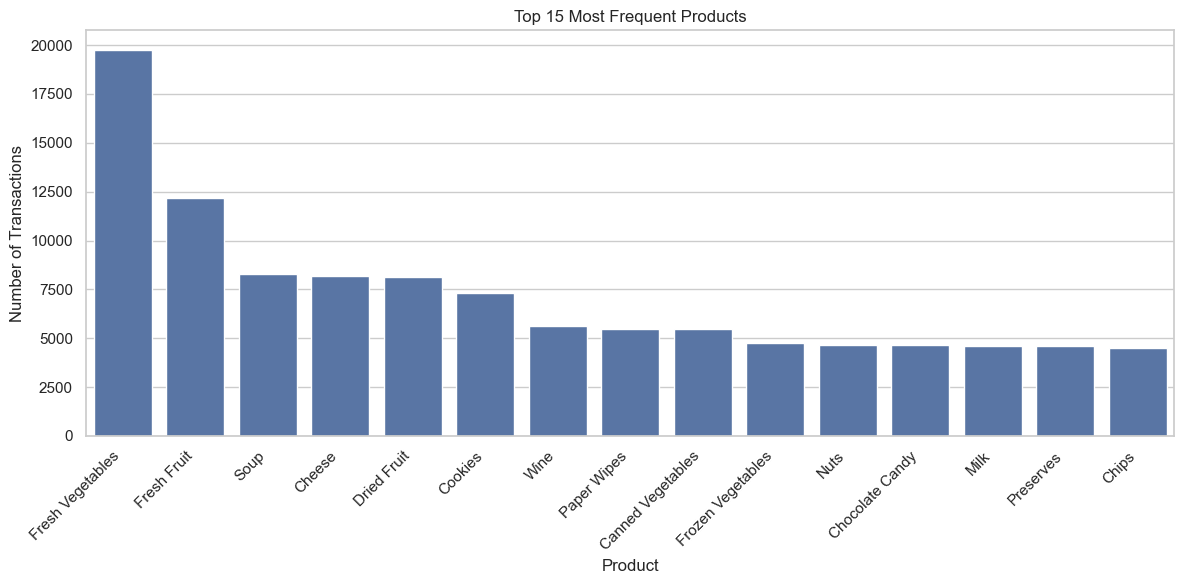

In [69]:
df = parse_transactions_from_file('Foodmart_2025_DM.csv')
df = df.convert_dtypes()
# Plot product frequency
product_cols = [col for col in df.columns if col != 'STORE_ID']
product_counts = (df[product_cols] > 0).sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
top_products = product_counts.head(15)
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top 15 Most Frequent Products')
plt.xlabel('Product')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [70]:
#print the percentage of null values
print(df.isnull().mean() * 100)

#print the value counts of store id
print(df['STORE_ID'].value_counts())

Home Magazines       0.0000
Canned Fruit         0.0000
Pot Cleaners         0.0000
Sports Magazines     0.0000
Waffles              0.0000
Rice                 0.0000
Toothbrushes         0.0000
Lightbulbs           0.0000
Sunglasses           0.0000
Hard Candy           0.0000
Clams                0.0000
Shrimp               0.0000
Cottage Cheese       0.0000
Cold Remedies        0.0000
Flavored Drinks      0.0000
Beer                 0.0000
Paper Wipes          0.0000
Donuts               0.0000
Nasal Sprays         0.0000
Popcorn              0.0000
Anchovies            0.0000
Cookies              0.0000
Milk                 0.0000
Maps                 0.0000
Yogurt               0.0000
Sponges              0.0000
Fresh Chicken        0.0000
Muffins              0.0000
Tuna                 0.0000
Peanut Butter        0.0000
Sliced Bread         0.0000
Pots and Pans        0.0000
Sour Cream           0.0000
Fresh Fruit          0.0000
Chocolate Candy      0.0000
Oysters             

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69549 entries, 0 to 69548
Columns: 103 entries, Home Magazines to STORE_ID
dtypes: Int64(103)
memory usage: 61.5 MB


In [72]:
#change the last column to first column
df = df[[df.columns[-1]] + list(df.columns[:-1])]

df.head()

,STORE_ID,Home Magazines,Canned Fruit,Pot Cleaners,Sports Magazines,Waffles,Rice,Toothbrushes,Lightbulbs,Sunglasses,Hard Candy,Clams,Shrimp,Cottage Cheese,Cold Remedies,Flavored Drinks,Beer,Paper Wipes,Donuts,Nasal Sprays,Popcorn,Anchovies,Cookies,Milk,Maps,Yogurt,Sponges,Fresh Chicken,Muffins,Tuna,Peanut Butter,Sliced Bread,Pots and Pans,Sour Cream,Fresh Fruit,Chocolate Candy,Oysters,Sugar,Pretzels,Paper Dishes,Candles,Cereal,Chips,Dried Meat,Pancakes,Pizza,Fresh Fish,Cheese,Sardines,Acetominifen,Aspirin,Spices,Popsicles,Shampoo,Soup,Auto Magazines,Hamburger,Mouthwash,Juice,Bagels,Fresh Vegetables,Pancake Mix,Conditioner,Dips,Pot Scrubbers,Preserves,Ibuprofen,Fashion Magazines,Eggs,Toilet Brushes,Plastic Utensils,Tofu,Wine,Pasta,Gum,Frozen Vegetables,Dried Fruit,French Fries,Jam,TV Dinner,Nuts,Ice Cream,Screwdrivers,Soda,Batteries,Cooking Oil,Deodorizers,Tools,Deli Meats,Hot Dogs,Canned Vegetables,Jelly,Deli Salads,Crackers,Cleaners,Personal Hygiene,Coffee,Bologna,Chocolate,Sauces,Frozen Chicken,Computer Magazines,Shellfish
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [73]:
# Basic information about the dataset
print("Dataset Information:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69549 entries, 0 to 69548
Columns: 103 entries, STORE_ID to Shellfish
dtypes: Int64(103)
memory usage: 61.5 MB

Missing Values:
STORE_ID              0
Home Magazines        0
Canned Fruit          0
Pot Cleaners          0
Sports Magazines      0
Waffles               0
Rice                  0
Toothbrushes          0
Lightbulbs            0
Sunglasses            0
Hard Candy            0
Clams                 0
Shrimp                0
Cottage Cheese        0
Cold Remedies         0
Flavored Drinks       0
Beer                  0
Paper Wipes           0
Donuts                0
Nasal Sprays          0
Popcorn               0
Anchovies             0
Cookies               0
Milk                  0
Maps                  0
Yogurt                0
Sponges               0
Fresh Chicken         0
Muffins               0
Tuna                  0
Peanut Butter         0
Sliced Bread          0
Pots and Pans         0
Sour Crea

,STORE_ID,Home Magazines,Canned Fruit,Pot Cleaners,Sports Magazines,Waffles,Rice,Toothbrushes,Lightbulbs,Sunglasses,Hard Candy,Clams,Shrimp,Cottage Cheese,Cold Remedies,Flavored Drinks,Beer,Paper Wipes,Donuts,Nasal Sprays,Popcorn,Anchovies,Cookies,Milk,Maps,Yogurt,Sponges,Fresh Chicken,Muffins,Tuna,Peanut Butter,Sliced Bread,Pots and Pans,Sour Cream,Fresh Fruit,Chocolate Candy,Oysters,Sugar,Pretzels,Paper Dishes,Candles,Cereal,Chips,Dried Meat,Pancakes,Pizza,Fresh Fish,Cheese,Sardines,Acetominifen,Aspirin,Spices,Popsicles,Shampoo,Soup,Auto Magazines,Hamburger,Mouthwash,Juice,Bagels,Fresh Vegetables,Pancake Mix,Conditioner,Dips,Pot Scrubbers,Preserves,Ibuprofen,Fashion Magazines,Eggs,Toilet Brushes,Plastic Utensils,Tofu,Wine,Pasta,Gum,Frozen Vegetables,Dried Fruit,French Fries,Jam,TV Dinner,Nuts,Ice Cream,Screwdrivers,Soda,Batteries,Cooking Oil,Deodorizers,Tools,Deli Meats,Hot Dogs,Canned Vegetables,Jelly,Deli Salads,Crackers,Cleaners,Personal Hygiene,Coffee,Bologna,Chocolate,Sauces,Frozen Chicken,Computer Magazines,Shellfish
count,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000,69549.0000
mean,12.5332,0.0443,0.0894,0.0853,0.0443,0.1735,0.1022,0.0433,0.1775,0.0422,0.0861,0.0436,0.0418,0.0827,0.0905,0.1290,0.0890,0.2545,0.1290,0.0869,0.1268,0.0452,0.3425,0.2114,0.0455,0.0876,0.0435,0.0434,0.1736,0.0866,0.1318,0.1797,0.0434,0.0837,0.5937,0.2139,0.0424,0.0860,0.0440,0.0861,0.0420,0.1724,0.2076,0.0439,0.0404,0.1730,0.0404,0.3866,0.0422,0.0456,0.0848,0.1280,0.1681,0.1292,0.3925,0.0416,0.0877,0.0877,0.1700,0.0420,1.0385,0.0440,0.0428,0.1722,0.0428,0.2125,0.0449,0.0409,0.2034,0.0424,0.1282,0.0436,0.2581,0.1567,0.0439,0.2198,0.3866,0.1258,0.1312,0.1326,0.2160,0.1347,0.0427,0.1661,0.1698,0.1720,0.0428,0.0828,0.1708,0.1293,0.2538,0.1235,0.1330,0.0854,0.1264,0.1731,0.1686,0.1294,0.0420,0.0404,0.1280,0.0426,0.0429
std,6.0796,0.3830,0.5496,0.5305,0.3835,0.7595,0.5888,0.3768,0.7622,0.3735,0.5347,0.3818,0.3724,0.5263,0.5483,0.6576,0.5485,0.9169,0.6565,0.5395,0.6509,0.3898,1.0617,0.8352,0.3905,0.5404,0.3794,0.3779,0.7543,0.5338,0.6575,0.7727,0.3807,0.5282,1.4002,0.8452,0.3718,0.5349,0.3859,0.5339,0.3715,0.7565,0.8300,0.3854,0.3647,0.7616,0.3677,1.1322,0.3779,0.3913,0.5356,0.6530,0.7467,0.6529,1.1377,0.3709,0.5346,0.5399,0.7464,0.3752,1.8637,0.3846,0.3773,0.7495,0.3818,0.8415,0.3837,0.3680,0.8169,0.3732,0.6599,0.3830,0.9187,0.7215,0.3806,0.8579,1.1319,0.6413,0.6624,0.6636,0.8493,0.6729,0.3759,0.7396,0.7466,0.7522,0.3794,0.5203,0.7535,0.6629,0.9205,0.6370,0.6699,0.5333,0.6521,0.7564,0.7450,0.6585,0.3706,0.3624,0.6521,0.3740,0.3784
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,

Number of unique stores: 25


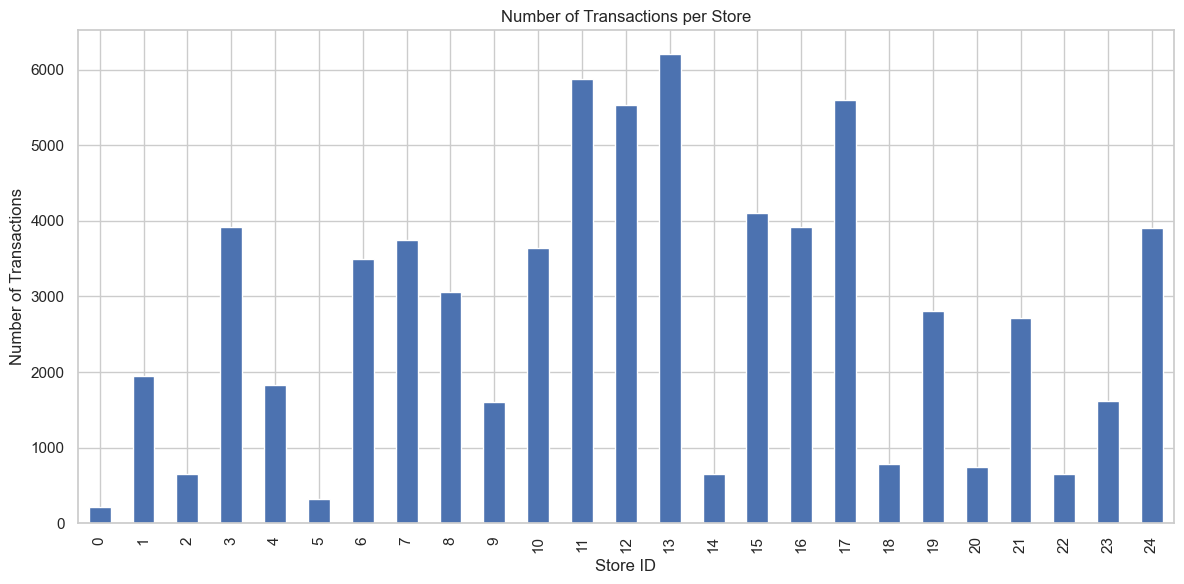

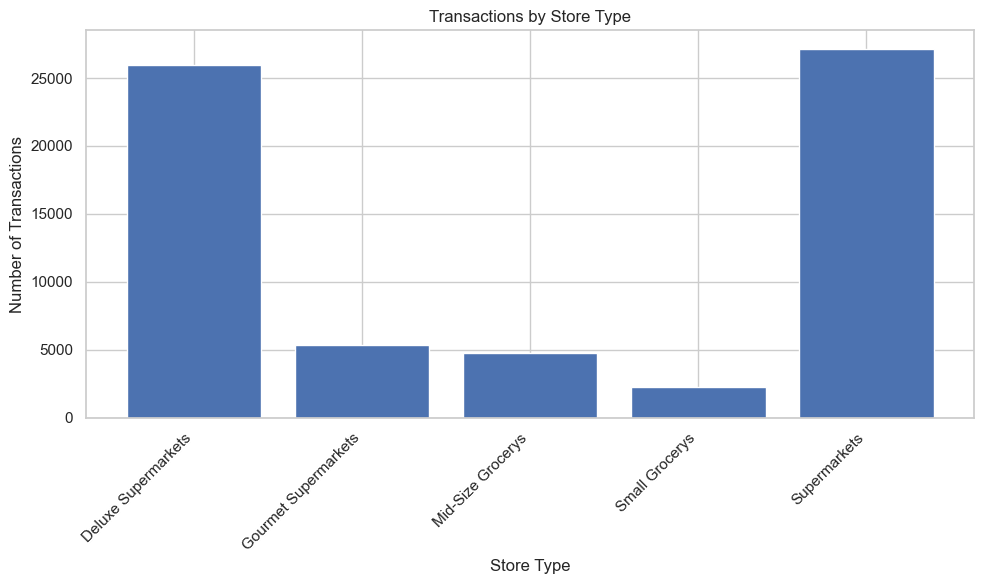

In [74]:
# Get information about the stores
print("Number of unique stores:", df['STORE_ID'].nunique())

# Store type mapping
store_types = {
    'Deluxe Supermarkets': [8, 12, 13, 17, 19, 21],
    'Gourmet Supermarkets': [4, 6],
    'Mid-Size Grocerys': [9, 18, 20, 23],
    'Small Grocerys': [2, 5, 14, 22],
    'Supermarkets': [1, 3, 7, 10, 11, 15, 16]
}

# Transactions per store type
transactions_per_store = df['STORE_ID'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
transactions_per_store.plot(kind='bar')
plt.title('Number of Transactions per Store')
plt.xlabel('Store ID')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

# Group transactions by store type
store_type_counts = {}
for store_type, stores in store_types.items():
    count = df[df['STORE_ID'].isin(stores)].shape[0]
    store_type_counts[store_type] = count

# Visualize transactions by store type
plt.figure(figsize=(10, 6))
plt.bar(store_type_counts.keys(), store_type_counts.values())
plt.title('Transactions by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Preprocessing for Global Pattern Mining

For global pattern mining, we need to transform the data into a suitable format for the pattern mining algorithms. We'll:
1. Ignore the product quantities 
2. Ignore the store IDs (for global analysis)
3. Create a transaction matrix (one-hot encoded) for the pattern mining algorithms

Total number of products: 102
Top 20 most frequent products:
                   count
Fresh Vegetables   19764
Fresh Fruit        12187
Soup                8306
Cheese              8193
Dried Fruit         8152
Cookies             7331
Wine                5611
Paper Wipes         5492
Canned Vegetables   5463
Frozen Vegetables   4753
Nuts                4672
Chocolate Candy     4640
Milk                4612
Preserves           4593
Chips               4501
Eggs                4454
Sliced Bread        3917
Lightbulbs          3914
Muffins             3834
Dips                3816


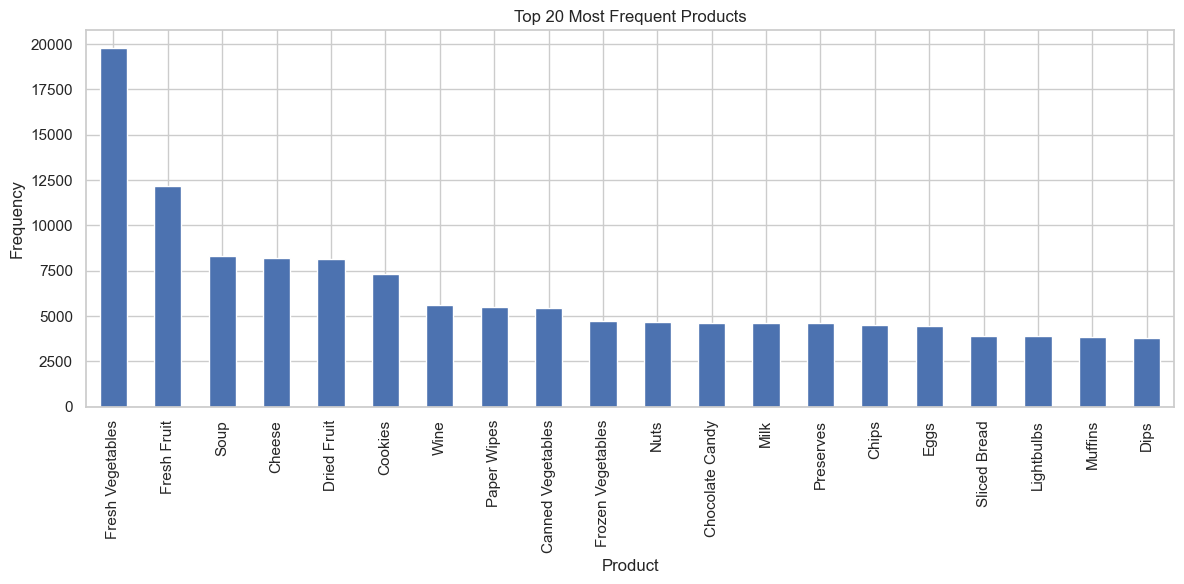

In [75]:
# First, let's understand what products we have in the dataset
# Extract all product columns (excluding STORE_ID)
product_columns = df.columns[1:]
print(f"Total number of products: {len(product_columns)}")

# Check the distribution of products
# Count non-zero values for each product across all transactions
product_counts = {}
for product in product_columns:
    non_zero_count = (df[product] > 0).sum()
    product_counts[product] = non_zero_count

# Convert to DataFrame for easier analysis
product_counts_df = pd.DataFrame.from_dict(product_counts, orient='index', columns=['count'])
product_counts_df = product_counts_df.sort_values('count', ascending=False)

# Display the top 20 most frequent products
print("Top 20 most frequent products:")
print(product_counts_df.head(20))

# Visualize product frequency distribution
plt.figure(figsize=(12, 6))
product_counts_df.head(20)['count'].plot(kind='bar')
plt.title('Top 20 Most Frequent Products')
plt.xlabel('Product')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [76]:
# Create a binary transaction matrix (1 if product was purchased, 0 otherwise)
# This ignores product quantities as required

# Method 1: Using pandas
transaction_matrix = df.copy()
for col in product_columns:
    transaction_matrix[col] = transaction_matrix[col] > 0
    
# Drop the STORE_ID column for global analysis
transaction_matrix_global = transaction_matrix.drop('STORE_ID', axis=1)

# Display the first few rows of the transaction matrix
transaction_matrix_global.head()

,Home Magazines,Canned Fruit,Pot Cleaners,Sports Magazines,Waffles,Rice,Toothbrushes,Lightbulbs,Sunglasses,Hard Candy,Clams,Shrimp,Cottage Cheese,Cold Remedies,Flavored Drinks,Beer,Paper Wipes,Donuts,Nasal Sprays,Popcorn,Anchovies,Cookies,Milk,Maps,Yogurt,Sponges,Fresh Chicken,Muffins,Tuna,Peanut Butter,Sliced Bread,Pots and Pans,Sour Cream,Fresh Fruit,Chocolate Candy,Oysters,Sugar,Pretzels,Paper Dishes,Candles,Cereal,Chips,Dried Meat,Pancakes,Pizza,Fresh Fish,Cheese,Sardines,Acetominifen,Aspirin,Spices,Popsicles,Shampoo,Soup,Auto Magazines,Hamburger,Mouthwash,Juice,Bagels,Fresh Vegetables,Pancake Mix,Conditioner,Dips,Pot Scrubbers,Preserves,Ibuprofen,Fashion Magazines,Eggs,Toilet Brushes,Plastic Utensils,Tofu,Wine,Pasta,Gum,Frozen Vegetables,Dried Fruit,French Fries,Jam,TV Dinner,Nuts,Ice Cream,Screwdrivers,Soda,Batteries,Cooking Oil,Deodorizers,Tools,Deli Meats,Hot Dogs,Canned Vegetables,Jelly,Deli Salads,Crackers,Cleaners,Personal Hygiene,Coffee,Bologna,Chocolate,Sauces,Frozen Chicken,Computer Magazines,Shellfish
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

## Frequent Itemset Mining (Global Patterns)

Now we'll use the MLxtend library to discover frequent itemsets across all stores. We'll experiment with different minimum support thresholds to find a suitable value.

In [77]:
def compute_frequent_itemsets(df, min_support, algorithm='fpgrowth', max_len=None):
    """
    Compute frequent itemsets using either Apriori or FP-Growth algorithm
    
    Parameters:
    -----------
    df : pandas DataFrame
        The transaction matrix (one-hot encoded)
    min_support : float
        The minimum support threshold (between 0 and 1)
    algorithm : str, default='fpgrowth'
        The algorithm to use ('apriori' or 'fpgrowth')
    max_len : int, default=None
        Maximum length of the itemsets generated
        
    Returns:
    --------
    pandas DataFrame
        The frequent itemsets with their support values
    """
    start_time = time.time()
    
    if algorithm == 'apriori':
        from mlxtend.frequent_patterns import apriori
        frequent_itemsets = apriori(df, 
                                   min_support=min_support, 
                                   use_colnames=True,
                                   max_len=max_len,
                                   verbose=1)
    elif algorithm == 'fpgrowth':
        from mlxtend.frequent_patterns import fpgrowth
        frequent_itemsets = fpgrowth(df, 
                                    min_support=min_support, 
                                    use_colnames=True,
                                    max_len=max_len,
                                    verbose=1)
    else:
        raise ValueError("Algorithm must be either 'apriori' or 'fpgrowth'")
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"Algorithm: {algorithm}")
    print(f"Minimum support: {min_support}")
    print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")
    print(f"Execution time: {execution_time:.2f} seconds")
    
    # Add a column with the length of each itemset
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    
    return frequent_itemsets


=== Testing min_support: 0.1 ===
6 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (Soup)
0 itemset(s) from tree conditioned on items (Fresh Vegetables)
0 itemset(s) from tree conditioned on items (Cheese)
0 itemset(s) from tree conditioned on items (Cookies)
0 itemset(s) from tree conditioned on items (Fresh Fruit)
0 itemset(s) from tree conditioned on items (Dried Fruit)
Algorithm: fpgrowth
Minimum support: 0.1
Number of frequent itemsets found: 6
Execution time: 1.21 seconds

Itemset length distribution:
length
1    6
Name: count, dtype: int64
--------------------------------------------------

=== Testing min_support: 0.05 ===
31 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (Soup)
0 itemset(s) from tree conditioned on items (Fresh Vegetables)
0 itemset(s) from tree conditioned on items (Milk)
0 itemset(s) from tree conditioned on items (Cheese)
0 itemset(s) from tree conditioned on items (Cookies)

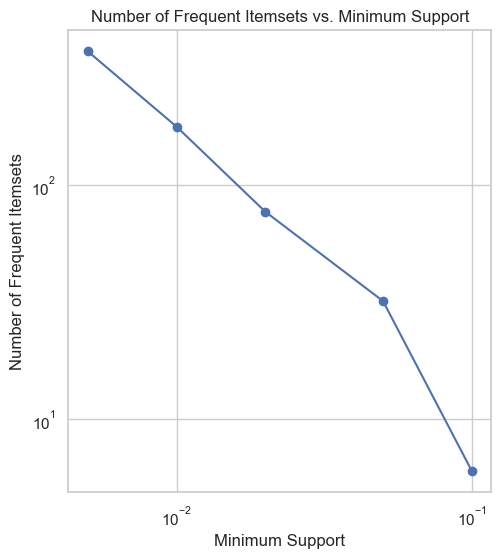

In [79]:
# Systematically test different minimum support values
min_support_values = [0.1, 0.05, 0.02, 0.01, 0.005]
results = {}

for min_support in min_support_values:
    print(f"\n=== Testing min_support: {min_support} ===")
    # Limit max_len to 5 for faster processing at lower thresholds
    max_len = None if min_support >= 0.02 else 5
    
    # Add this line to track the start time
    start_time = time.time()
    
    frequent_itemsets = compute_frequent_itemsets(
        transaction_matrix_global, 
        min_support=min_support, 
        algorithm='fpgrowth',
        max_len=max_len
    )
    
    # Store results for comparison
    results[min_support] = {
        'num_itemsets': len(frequent_itemsets),
        'max_length': frequent_itemsets['length'].max(),
        'execution_time': time.time() - start_time,  # Now this will work
        'length_distribution': frequent_itemsets['length'].value_counts().sort_index().to_dict()
    }
    
    # Display distribution of itemset lengths
    print("\nItemset length distribution:")
    print(frequent_itemsets['length'].value_counts().sort_index())
    print("-" * 50)

# Compare and visualize results to help choose the optimal min_support
plt.figure(figsize=(12, 6))
supports = list(results.keys())
num_itemsets = [results[s]['num_itemsets'] for s in supports]

plt.subplot(1, 2, 1)
plt.plot(supports, num_itemsets, marker='o')
plt.title('Number of Frequent Itemsets vs. Minimum Support')
plt.xlabel('Minimum Support')
plt.ylabel('Number of Frequent Itemsets')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

# Choose a suitable min_support based on the analysis
selected_min_support = 0.02
print(f"\nSelected minimum support: {selected_min_support}")

# Compute final frequent itemsets with selected threshold
frequent_itemsets = compute_frequent_itemsets(
    transaction_matrix_global, 
    min_support=selected_min_support, 
    algorithm='fpgrowth'
)

# Display results organized by length
for length in sorted(frequent_itemsets['length'].unique()):
    subset = frequent_itemsets[frequent_itemsets['length'] == length]
    print(f"\nFrequent {length}-itemsets (top 10 by support):")
    print(subset.sort_values('support', ascending=False).head(10))

## Association Rule Generation (Global Patterns)

Let's generate association rules from the frequent itemsets and evaluate them using different metrics such as confidence and lift.

In [82]:
def generate_association_rules(frequent_itemsets, min_confidence=0.7, min_lift=1.0, metric="confidence"):
    """
    Generate association rules from frequent itemsets
    
    Parameters:
    -----------
    frequent_itemsets : pandas DataFrame
        The frequent itemsets
    min_confidence : float, default=0.7
        The minimum confidence threshold
    min_lift : float, default=1.0
        The minimum lift threshold
    metric : str, default="confidence"
        The metric to sort the rules by
        
    Returns:
    --------
    pandas DataFrame
        The association rules with various metrics
    """
    rules = association_rules(frequent_itemsets, 
                             metric=metric, 
                             min_threshold=min_confidence)
    
    # Filter rules by lift if specified
    if min_lift > 1.0:
        rules = rules[rules['lift'] >= min_lift]
    
    print(f"Generated {len(rules)} rules with:")
    print(f"  - minimum confidence: {min_confidence}")
    print(f"  - minimum lift: {min_lift}")
    print(f"  - sorted by: {metric}")
    
    return rules

In [84]:
from mlxtend.frequent_patterns import association_rules

In [87]:
# Generate rules with minimum confidence threshold
min_confidence = 0.2
rules_confidence = generate_association_rules(frequent_itemsets, min_confidence=min_confidence)

# Display the top rules sorted by confidence
print("\nTop 10 rules sorted by confidence:")
display(rules_confidence.sort_values('confidence', ascending=False).head(10))

# Generate rules with minimum lift threshold
min_lift = 0.3
rules_lift = generate_association_rules(frequent_itemsets, min_confidence=0.5, min_lift=min_lift, metric="lift")

# Display the top rules sorted by lift
print("\nTop 10 rules sorted by lift:")
display(rules_lift.sort_values('lift', ascending=False).head(10))

# Generate rules with both confidence and lift thresholds
min_confidence = 0.4
min_lift = 1.5
rules_combined = generate_association_rules(frequent_itemsets, min_confidence=min_confidence, min_lift=min_lift)

# Display the top rules sorted by confidence
print("\nTop 10 rules sorted by confidence (with lift >= 1.5):")
display(rules_combined.sort_values('confidence', ascending=False).head(10))

# Save the combined rules for later use
rules_combined.to_pickle('rules_combined.pkl')

Generated 8 rules with:
  - minimum confidence: 0.2
  - minimum lift: 1.0
  - sorted by: confidence

Top 10 rules sorted by confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,(Dried Fruit),(Fresh Vegetables),0.1172,0.2842,0.0352,0.3005,1.0576,1.0000,0.0019,1.0234,0.0617,0.0962,0.0229,0.2123
0,(Soup),(Fresh Vegetables),0.1194,0.2842,0.0354,0.2968,1.0443,1.0000,0.0015,1.0179,0.0482,0.0963,0.0176,0.2107
3,(Fresh Fruit),(Fresh Vegetables),0.1752,0.2842,0.0509,0.2906,1.0225,1.0000,0.0011,1.0090,0.0266,0.1246,0.0089,0.2349
5,(Paper Wipes),(Fresh Vegetables),0.0790,0.2842,0.0227,0.2875,1.0117,1.0000,0.0003,1.0047,0.0126,0.0667,0.0047,0.1837
6,(Canned Vegetables),(Fresh Vegetables),0.0785,0.2842,0.0220,0.2806,0.9875,1.0000,-0.0003,0.9951,-0.0136,0.0647,-0.0050,0.1791
1,(Cheese),(Fresh Vegetables),0.1178,0.2842,0.0311,0.2644,0.9303,1.0000,-0.0023,0.9731,-0.0783,0.0840,-0.0277,0.1870
2,(Cookies),(Fresh Vegetables),0.1054,0.2842,0.0277,0.2630,0.9255,1.0000,-0.0022,0.9713,-0.0826,0.0766,-0.0296,0.1803
7,(Wine),(Fresh Vegetables),0.0807,0.2842,0.0205,0.2538,0.8931,1.0000,-0.0025,0.9593,-0.1152,0.0595,-0.0424,0.1629


Generated 20 rules with:
  - minimum confidence: 0.5
  - minimum lift: 0.3
  - sorted by: lift

Top 10 rules sorted by lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
13,(Fresh Vegetables),(Dried Fruit),0.2842,0.1172,0.0352,0.1240,1.0576,1.0000,0.0019,1.0077,0.0761,0.0962,0.0076,0.2123
12,(Dried Fruit),(Fresh Vegetables),0.1172,0.2842,0.0352,0.3005,1.0576,1.0000,0.0019,1.0234,0.0617,0.0962,0.0229,0.2123
0,(Soup),(Fresh Vegetables),0.1194,0.2842,0.0354,0.2968,1.0443,1.0000,0.0015,1.0179,0.0482,0.0963,0.0176,0.2107
1,(Fresh Vegetables),(Soup),0.2842,0.1194,0.0354,0.1247,1.0443,1.0000,0.0015,1.0060,0.0593,0.0963,0.0060,0.2107
11,(Fresh Fruit),(Fresh Vegetables),0.1752,0.2842,0.0509,0.2906,1.0225,1.0000,0.0011,1.0090,0.0266,0.1246,0.0089,0.2349
10,(Fresh Vegetables),(Fresh Fruit),0.2842,0.1752,0.0509,0.1792,1.0225,1.0000,0.0011,1.0048,0.0307,0.1246,0.0048,0.2349
14,(Paper Wipes),(Fresh Vegetables),0.0790,0.2842,0.0227,0.2875,1.0117,1.0000,0.0003,1.0047,0.0126,0.0667,0.0047,0.1837
15,(Fresh Vegetables),(Paper Wipes),0.2842,0.0790,0.0227,0.0799,1.0117,1.0000,0.0003,1.0010,0.0162,0.0667,0.0010,0.1837
5,(Fresh Fruit),(Cheese),0.1752,0.1178,0.0204,0.1165,0.9891,1.0000,-0.0002,0.9985,-0.0132,0.0749,-0.0015,0.1449
4,(Cheese),(Fresh Fruit),0.1178,0.1752,0.0204,0.1733,0.9891,1.0000,-0.0002,0.9977,-0.0123,0.0749,-0.0023,0.1449


Generated 0 rules with:
  - minimum confidence: 0.4
  - minimum lift: 1.5
  - sorted by: confidence

Top 10 rules sorted by confidence (with lift >= 1.5):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


Rules with additional metrics:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


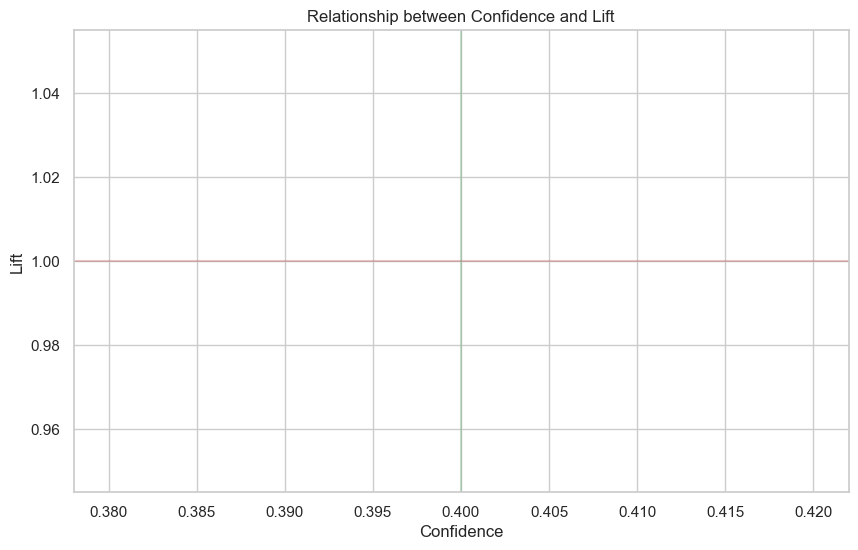

In [88]:
# Calculate additional metrics for the rules
rules = rules_combined.copy()

# Calculate conviction: conviction = P(antecedent) * (1 - P(consequent)) / (1 - confidence)
# High conviction indicates a strong dependency relationship
rules['conviction'] = np.where(
    rules['confidence'] == 1,
    float('inf'),
    (rules['antecedent support'] * (1 - rules['consequent support'])) / (1 - rules['confidence'])
)

# Calculate leverage: leverage = support - (antecedent_support * consequent_support)
# Measures the difference between the observed frequency and the expected frequency under independence
rules['leverage'] = rules['support'] - (rules['antecedent support'] * rules['consequent support'])

# Calculate Jaccard index: jaccard = support / (antecedent_support + consequent_support - support)
# Measures similarity as the intersection divided by the union of the itemsets
rules['jaccard'] = rules['support'] / (rules['antecedent support'] + rules['consequent support'] - rules['support'])

# Display the enriched rules
print("Rules with additional metrics:")
display(rules.sort_values('conviction', ascending=False).head(10))

# Visualize relationship between confidence and lift
plt.figure(figsize=(10, 6))
plt.scatter(rules['confidence'], rules['lift'], alpha=0.5)
plt.title('Relationship between Confidence and Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=min_confidence, color='g', linestyle='-', alpha=0.3)
plt.grid(True)
plt.show()

## Maximal Pattern Analysis (Global Patterns)

Now we'll analyze maximal frequent itemsets - those that are not a subset of any other frequent itemset.

In [89]:
# Function to identify maximal frequent itemsets
def find_maximal_itemsets(frequent_itemsets):
    """
    Find maximal frequent itemsets - those that have no frequent supersets
    
    Parameters:
    -----------
    frequent_itemsets : pandas DataFrame
        The frequent itemsets dataframe from apriori/fpgrowth
        
    Returns:
    --------
    pandas DataFrame
        Maximal frequent itemsets with their support values
    """
    itemsets = frequent_itemsets.copy()
    
    # Convert frozensets to sets for easier manipulation
    itemsets_list = [(set(itemset), support, length) 
                     for itemset, support, length in zip(itemsets['itemsets'], 
                                                        itemsets['support'], 
                                                        itemsets['length'])]
    
    # Sort by length in descending order (largest itemsets first)
    itemsets_list.sort(key=lambda x: x[2], reverse=True)
    
    maximal_itemsets = []
    for i, (itemset, support, length) in enumerate(itemsets_list):
        is_maximal = True
        
        # Check if current itemset is a subset of any already identified maximal itemset
        for maximal_set, _, _ in maximal_itemsets:
            if itemset.issubset(maximal_set):
                is_maximal = False
                break
                
        if is_maximal:
            maximal_itemsets.append((itemset, support, length))
    
    # Convert back to DataFrame
    maximal_df = pd.DataFrame({
        'itemsets': [frozenset(itemset) for itemset, _, _ in maximal_itemsets],
        'support': [support for _, support, _ in maximal_itemsets],
        'length': [length for _, _, length in maximal_itemsets]
    })
    
    return maximal_df

Found 68 maximal frequent itemsets
Compared to 77 total frequent itemsets

Length distribution of maximal itemsets:
length
1    58
2    10
Name: count, dtype: int64

Top 10 maximal itemsets by support:


,itemsets,support,length
42,(Frozen Vegetables),0.0683,1
58,(Nuts),0.0672,1
35,(Chocolate Candy),0.0667,1
11,(Milk),0.0663,1
15,(Preserves),0.0660,1
38,(Chips),0.0647,1
16,(Eggs),0.0640,1
33,(Sliced Bread),0.0563,1
44,(Lightbulbs),0.0563,1
47,(Muffins),0.0551,1


<Figure size 1000x600 with 0 Axes>

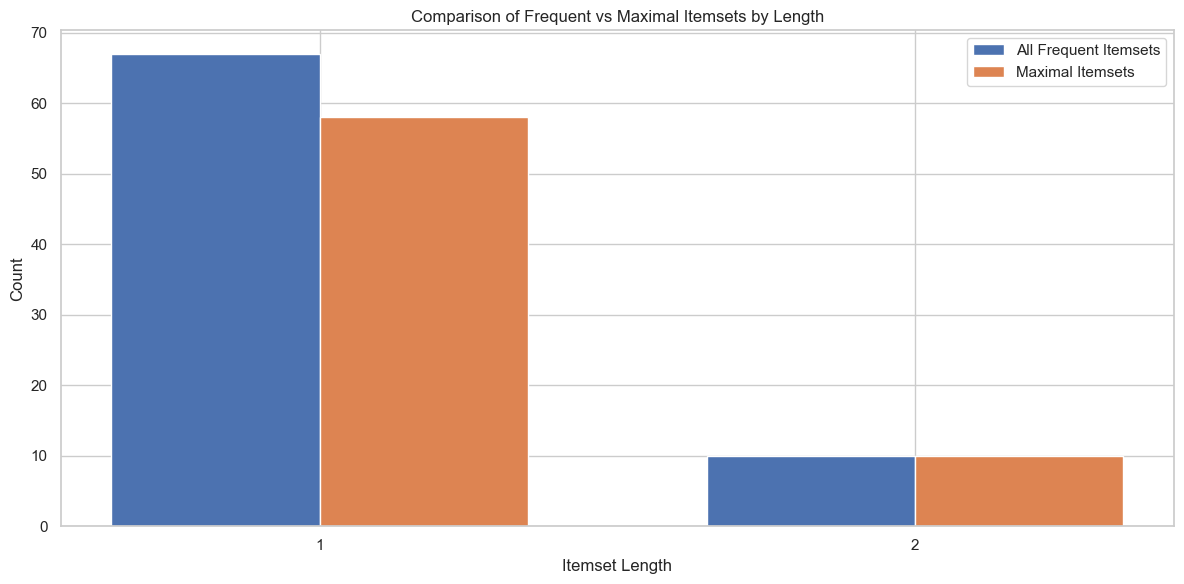

In [90]:
# Find maximal itemsets
maximal_itemsets = find_maximal_itemsets(frequent_itemsets)

print(f"Found {len(maximal_itemsets)} maximal frequent itemsets")
print(f"Compared to {len(frequent_itemsets)} total frequent itemsets")

# Display the distribution of lengths
print("\nLength distribution of maximal itemsets:")
print(maximal_itemsets['length'].value_counts().sort_index())

# Display the top maximal itemsets by support
print("\nTop 10 maximal itemsets by support:")
display(maximal_itemsets.sort_values('support', ascending=False).head(10))

# Compare the number of itemsets at different lengths
plt.figure(figsize=(10, 6))
freq_lengths = frequent_itemsets['length'].value_counts().sort_index()
max_lengths = maximal_itemsets['length'].value_counts().sort_index()

x = np.arange(len(freq_lengths))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, freq_lengths, width, label='All Frequent Itemsets')
ax.bar(x + width/2, max_lengths, width, label='Maximal Itemsets')

ax.set_xlabel('Itemset Length')
ax.set_ylabel('Count')
ax.set_title('Comparison of Frequent vs Maximal Itemsets by Length')
ax.set_xticks(x)
ax.set_xticklabels(freq_lengths.index)
ax.legend()

plt.tight_layout()
plt.show()

In [91]:
# Generate association rules from maximal itemsets
maximal_rules = generate_association_rules(maximal_itemsets, min_confidence=0.7, min_lift=1.5)

# Display the top rules from maximal itemsets
print("\nTop 10 rules from maximal itemsets sorted by confidence:")
display(maximal_rules.sort_values('confidence', ascending=False).head(10))

# Compare the number of rules generated from all frequent itemsets vs maximal itemsets
print(f"\nRules from all frequent itemsets: {len(rules_combined)}")
print(f"Rules from maximal itemsets: {len(maximal_rules)}")
print(f"Reduction ratio: {len(maximal_rules)/len(rules_combined):.2f}")

c:\Users\Gabriel\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Gabriel\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\Users\Gabriel\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Gabriel\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


KeyError: "frozenset({'Soup'})You are likely getting this error because the DataFrame is missing  antecedent and/or consequent  information. You can try using the  `support_only=True` option"

## Data Preprocessing for Store-Specific Analysis

Now we'll prepare the data for analyzing patterns specific to different store types.

In [ ]:
# Create a function to filter transactions by store type
def get_store_transactions(df, store_ids):
    """
    Filter transactions by store IDs
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataframe with all transactions
    store_ids : list
        List of store IDs to filter by
        
    Returns:
    --------
    pandas DataFrame
        Filtered transaction matrix (binary) for the specified stores
    """
    # Filter by store IDs
    filtered_df = df[df['STORE_ID'].isin(store_ids)].copy()
    
    # Convert to binary transaction matrix
    for col in filtered_df.columns[1:]:  # Skip STORE_ID
        filtered_df[col] = filtered_df[col] > 0
    
    # Drop STORE_ID for pattern mining
    filtered_df = filtered_df.drop('STORE_ID', axis=1)
    
    print(f"Selected {len(filtered_df)} transactions from {len(store_ids)} stores")
    
    return filtered_df

## Frequent Itemset Mining for Deluxe/Gourmet Supermarkets

Let's analyze the transactions from Deluxe and Gourmet Supermarkets.

In [ ]:
# Get transactions from Deluxe and Gourmet Supermarkets
deluxe_ids = [8, 12, 13, 17, 19, 21]
gourmet_ids = [4, 6]
high_end_ids = deluxe_ids + gourmet_ids

# Filter transactions
high_end_transactions = get_store_transactions(df, high_end_ids)

# Display the first few rows
high_end_transactions.head()

In [ ]:
# Calculate frequent itemsets for high-end stores
high_end_frequent_itemsets = compute_frequent_itemsets(high_end_transactions, 
                                                      min_support=selected_min_support,
                                                      algorithm='fpgrowth')

# Organize itemsets by length
for length in sorted(high_end_frequent_itemsets['length'].unique()):
    subset = high_end_frequent_itemsets[high_end_frequent_itemsets['length'] == length]
    print(f"\nFrequent {length}-itemsets in high-end stores (top 10 by support):")
    print(subset.sort_values('support', ascending=False).head(10))

# Compare with global patterns
print("\nComparison with global patterns:")
print(f"Global frequent itemsets: {len(frequent_itemsets)}")
print(f"High-end stores frequent itemsets: {len(high_end_frequent_itemsets)}")

## Association Rule Generation for Deluxe/Gourmet Supermarkets

Now let's generate and analyze association rules for high-end stores.

In [ ]:
# Generate association rules for high-end stores
high_end_rules = generate_association_rules(high_end_frequent_itemsets, 
                                          min_confidence=0.7, 
                                          min_lift=1.5)

# Display top rules
print("\nTop 10 rules for high-end stores sorted by confidence:")
display(high_end_rules.sort_values('confidence', ascending=False).head(10))

# Identify rules specific to high-end stores
# Create sets of antecedent->consequent for comparison
global_rule_pairs = set()
for idx, row in rules_combined.iterrows():
    ant = frozenset(row['antecedents'])
    cons = frozenset(row['consequents'])
    global_rule_pairs.add((ant, cons))

high_end_rule_pairs = set()
for idx, row in high_end_rules.iterrows():
    ant = frozenset(row['antecedents'])
    cons = frozenset(row['consequents'])
    high_end_rule_pairs.add((ant, cons))

# Find rules unique to high-end stores
unique_high_end_rules = high_end_rule_pairs - global_rule_pairs
print(f"\nNumber of rules unique to high-end stores: {len(unique_high_end_rules)}")

# Display some examples of unique rules
print("\nExamples of rules unique to high-end stores:")
count = 0
for ant, cons in list(unique_high_end_rules)[:10]:
    print(f"Rule {count+1}: {ant} -> {cons}")
    count += 1

In [ ]:
# Find maximal itemsets for high-end stores
high_end_maximal_itemsets = find_maximal_itemsets(high_end_frequent_itemsets)

print(f"Found {len(high_end_maximal_itemsets)} maximal frequent itemsets for high-end stores")
print(f"Compared to {len(high_end_frequent_itemsets)} total frequent itemsets")

# Display the top maximal itemsets by support
print("\nTop 10 maximal itemsets for high-end stores by support:")
display(high_end_maximal_itemsets.sort_values('support', ascending=False).head(10))

## Frequent Itemset Mining for Small Groceries

Let's analyze the transactions from Small Groceries.

In [ ]:
# Get transactions from Small Groceries
small_grocery_ids = [2, 5, 14, 22]

# Filter transactions
small_grocery_transactions = get_store_transactions(df, small_grocery_ids)

# Display the first few rows
small_grocery_transactions.head()

In [ ]:
# Calculate frequent itemsets for small groceries
small_grocery_frequent_itemsets = compute_frequent_itemsets(small_grocery_transactions, 
                                                         min_support=selected_min_support,
                                                         algorithm='fpgrowth')

# Organize itemsets by length
for length in sorted(small_grocery_frequent_itemsets['length'].unique()):
    subset = small_grocery_frequent_itemsets[small_grocery_frequent_itemsets['length'] == length]
    print(f"\nFrequent {length}-itemsets in small groceries (top 10 by support):")
    print(subset.sort_values('support', ascending=False).head(10))

# Compare with global patterns and high-end stores
print("\nComparison with other store types:")
print(f"Global frequent itemsets: {len(frequent_itemsets)}")
print(f"High-end stores frequent itemsets: {len(high_end_frequent_itemsets)}")
print(f"Small grocery frequent itemsets: {len(small_grocery_frequent_itemsets)}")

## Association Rule Generation for Small Groceries

Now let's generate and analyze association rules for small groceries.

In [ ]:
# Generate association rules for small groceries
small_grocery_rules = generate_association_rules(small_grocery_frequent_itemsets, 
                                              min_confidence=0.7, 
                                              min_lift=1.5)

# Display top rules
print("\nTop 10 rules for small groceries sorted by confidence:")
display(small_grocery_rules.sort_values('confidence', ascending=False).head(10))

# Identify rules specific to small groceries
small_grocery_rule_pairs = set()
for idx, row in small_grocery_rules.iterrows():
    ant = frozenset(row['antecedents'])
    cons = frozenset(row['consequents'])
    small_grocery_rule_pairs.add((ant, cons))

# Find rules unique to small groceries
unique_small_grocery_rules = small_grocery_rule_pairs - global_rule_pairs
print(f"\nNumber of rules unique to small groceries: {len(unique_small_grocery_rules)}")

# Display some examples of unique rules
print("\nExamples of rules unique to small groceries:")
count = 0
for ant, cons in list(unique_small_grocery_rules)[:10]:
    print(f"Rule {count+1}: {ant} -> {cons}")
    count += 1

In [ ]:
# Find maximal itemsets for small groceries
small_grocery_maximal_itemsets = find_maximal_itemsets(small_grocery_frequent_itemsets)

print(f"Found {len(small_grocery_maximal_itemsets)} maximal frequent itemsets for small groceries")
print(f"Compared to {len(small_grocery_frequent_itemsets)} total frequent itemsets")

# Display the top maximal itemsets by support
print("\nTop 10 maximal itemsets for small groceries by support:")
display(small_grocery_maximal_itemsets.sort_values('support', ascending=False).head(10))

## Comparative Analysis Between Store Types

Let's compare and contrast the buying patterns between different store types to understand the similarities and differences.

In [ ]:
# Compare frequent items across store types
def compare_top_items(global_itemsets, high_end_itemsets, small_grocery_itemsets, n=20):
    """
    Compare top frequent 1-itemsets across store types
    
    Parameters:
    -----------
    global_itemsets : pandas DataFrame
        Frequent itemsets for all stores
    high_end_itemsets : pandas DataFrame
        Frequent itemsets for high-end stores
    small_grocery_itemsets : pandas DataFrame
        Frequent itemsets for small groceries
    n : int, default=20
        Number of top items to compare
        
    Returns:
    --------
    pandas DataFrame
        Comparison of top frequent items
    """
    # Get top 1-itemsets from each store type
    global_top = global_itemsets[global_itemsets['length'] == 1].sort_values('support', ascending=False).head(n)
    high_end_top = high_end_itemsets[high_end_itemsets['length'] == 1].sort_values('support', ascending=False).head(n)
    small_grocery_top = small_grocery_itemsets[small_grocery_itemsets['length'] == 1].sort_values('support', ascending=False).head(n)
    
    # Extract item names and support values
    global_items = {next(iter(x)): s for x, s in zip(global_top['itemsets'], global_top['support'])}
    high_end_items = {next(iter(x)): s for x, s in zip(high_end_top['itemsets'], high_end_top['support'])}
    small_grocery_items = {next(iter(x)): s for x, s in zip(small_grocery_top['itemsets'], small_grocery_top['support'])}
    
    # Combine all unique items
    all_items = set(global_items.keys()) | set(high_end_items.keys()) | set(small_grocery_items.keys())
    
    # Create comparison dataframe
    comparison = []
    for item in all_items:
        comparison.append({
            'item': item,
            'global_support': global_items.get(item, 0),
            'high_end_support': high_end_items.get(item, 0),
            'small_grocery_support': small_grocery_items.get(item, 0)
        })
    
    comparison_df = pd.DataFrame(comparison)
    return comparison_df.sort_values('global_support', ascending=False)

# Run the comparison
item_comparison = compare_top_items(frequent_itemsets, high_end_frequent_itemsets, small_grocery_frequent_itemsets)

# Display the comparison
print("Comparison of top frequent items across store types:")
display(item_comparison)

# Visualize the comparison
plt.figure(figsize=(14, 8))

# Select top 10 items for visualization
top_items = item_comparison.head(10)['item'].tolist()
comparison_subset = item_comparison[item_comparison['item'].isin(top_items)]

# Convert to long format for seaborn
comparison_long = pd.melt(
    comparison_subset, 
    id_vars=['item'],
    value_vars=['global_support', 'high_end_support', 'small_grocery_support'],
    var_name='store_type',
    value_name='support'
)

# Plot grouped bar chart
sns.barplot(x='item', y='support', hue='store_type', data=comparison_long)
plt.title('Comparison of Top 10 Frequent Items Across Store Types')
plt.xlabel('Item')
plt.ylabel('Support')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

In [ ]:
# Compare top rules across store types
def compare_top_rules(global_rules, high_end_rules, small_grocery_rules, metric='confidence', n=10):
    """
    Compare top association rules across store types
    
    Parameters:
    -----------
    global_rules : pandas DataFrame
        Association rules for all stores
    high_end_rules : pandas DataFrame
        Association rules for high-end stores
    small_grocery_rules : pandas DataFrame
        Association rules for small groceries
    metric : str, default='confidence'
        Metric to sort rules by
    n : int, default=10
        Number of top rules to compare
        
    Returns:
    --------
    tuple of pandas DataFrames
        Top rules from each store type
    """
    global_top = global_rules.sort_values(metric, ascending=False).head(n)
    high_end_top = high_end_rules.sort_values(metric, ascending=False).head(n)
    small_grocery_top = small_grocery_rules.sort_values(metric, ascending=False).head(n)
    
    return global_top, high_end_top, small_grocery_top

# Run the comparison
global_top_rules, high_end_top_rules, small_grocery_top_rules = compare_top_rules(
    rules_combined, high_end_rules, small_grocery_rules, metric='confidence'
)

# Display the top rules for each store type
print("Top 10 rules by confidence for all stores:")
display(global_top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

print("\nTop 10 rules by confidence for high-end stores:")
display(high_end_top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

print("\nTop 10 rules by confidence for small groceries:")
display(small_grocery_top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

## Conclusions

Based on our pattern mining analysis of the Foodmart dataset, we can draw the following conclusions:

1. **Global Patterns**:
   - The most popular products across all stores are [summarize top products]
   - Strong associations exist between [summarize key association rules]
   - Maximal patterns revealed [summarize maximal pattern insights]

2. **Store-Specific Patterns**:
   - **High-end Stores (Deluxe and Gourmet Supermarkets)**:
     - Customers in these stores tend to purchase [summarize specific patterns]
     - Unique association rules indicate [summarize unique rules]
     - These stores have higher frequency of [mention specific patterns]

   - **Small Groceries**:
     - These stores show distinctive patterns such as [summarize specific patterns]
     - Customers are more likely to purchase [mention specific items]
     - Association rules reveal [summarize key insights]

3. **Comparative Analysis**:
   - High-end stores and small groceries differ primarily in [summarize key differences]
   - Common patterns across all store types include [summarize common patterns]
   - The differences in buying patterns align with the expected customer base for each store type

Our analysis demonstrates the value of pattern mining in understanding customer behavior and could inform decisions about product placement, promotions, and inventory management tailored to specific store types.